# Setup environment

In [1]:
from google.colab import drive
import os
from numpy import loadtxt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
random_seed = 1

In [2]:
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


# Loading the features

In [3]:
image_feature_folder = "/gdrive/MyDrive/Final Project/Data/Features"
model_weights_folder = "/gdrive/MyDrive/Final Project/Data/Models"
data_max_size = 19000

In [4]:
def get_saved_features(feature_folder):
  feature_files = os.listdir(feature_folder)
  print("Found {} files in dir {}".format(len(feature_files), feature_folder))
  features = []
  for feature_file in tqdm(feature_files, leave = False):
    features.append(loadtxt(feature_folder + "/" + feature_file, delimiter = ","))
  return np.concatenate(features, axis=0)[:data_max_size]
def get_features_path(model_name, class_name):
  path = os.path.join(image_feature_folder, class_name, model_name)
  return path


In [5]:
models = ["resnet_model", "vgg16_model"]
classes = ["Generated","Real"]
features = {
    model_name : {class_name : get_saved_features(get_features_path(model_name, class_name)) for class_name in classes } for model_name in models 
}
features

Found 304 files in dir /gdrive/MyDrive/Final Project/Data/Features/Generated/resnet_model


Found 375 files in dir /gdrive/MyDrive/Final Project/Data/Features/Real/resnet_model


Found 302 files in dir /gdrive/MyDrive/Final Project/Data/Features/Generated/vgg16_model


Found 375 files in dir /gdrive/MyDrive/Final Project/Data/Features/Real/vgg16_model


{'resnet_model': {'Generated': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.00308515,
          0.        ]]), 'Real': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])},
 'vgg16_model': {'Generated': array([[0.        , 0.3995837 , 0.19391933, ..., 0.        , 0.        ,
 

In [6]:
def get_data_splits(features):
  data_splits = {}
  for model_name, class_splits in features.items():
    X = np.concatenate((class_splits["Generated"], class_splits["Real"]))
    Y = np.array([1] * len(class_splits["Generated"]) + [0] * len(class_splits["Real"]))
    train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size=0.15, stratify=Y, random_state=random_seed)
    train_x, val_x, train_y, val_y = train_test_split(X,Y, test_size=0.10, stratify=Y, random_state=random_seed)
    data_splits[model_name] = {
        "train_x" : train_x,
        "train_y" : train_y,
        "val_x" : val_x,
        "val_y" : val_y,
        "test_x" : test_x,
        "test_y" : test_y
    }
    print(f"Created splits for {model_name}: ", {key : val.shape for key, val in data_splits[model_name].items()})
  return data_splits
data_splits = get_data_splits(features)

#Delete to save up some space in ram
del features

data_splits

Created splits for resnet_model:  {'train_x': (34200, 2048), 'train_y': (34200,), 'val_x': (3800, 2048), 'val_y': (3800,), 'test_x': (5700, 2048), 'test_y': (5700,)}
Created splits for vgg16_model:  {'train_x': (34200, 4096), 'train_y': (34200,), 'val_x': (3800, 4096), 'val_y': (3800,), 'test_x': (5700, 4096), 'test_y': (5700,)}


{'resnet_model': {'train_x': array([[0.        , 0.        , 0.        , ..., 0.        , 0.23608889,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        , 0.07298615,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.0025507 , 0.00148439,
          0.        ],
         [0.        , 0.        , 0.0107245 , ..., 0.        , 0.        ,
          0.        ]]),
  'train_y': array([1, 1, 1, ..., 1, 1, 1]),
  'val_x': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         ...,
       

In [7]:
def extract_data_splits(pretrain_type):
  data_split = data_splits[pretrain_type]
  return data_split["train_x"], data_split["train_y"], data_split["val_x"], data_split["val_y"], data_split["test_x"],data_split["test_y"]

# Model training and evaluation

## Fixing model architectures

Once we have the features extracted, we now train a model to predict of the question is answerable in the image or not.

In [8]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import Sequential

In [9]:
models = {}
input_shapes = { model_name : data['train_x'].shape[1] for model_name, data in data_splits.items() }
input_shapes

{'resnet_model': 2048, 'vgg16_model': 4096}

### Model 1 

In [10]:
def get_base_model(input_shape, verbose= True):
  model = Sequential()
  model.add(Input(shape = (input_shape)))
  model.add(Dense(2048, activation = 'relu'))
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
  if verbose:
    model.summary()
  return model
models["base_model"] = {model_name : get_base_model(input_shape) for model_name, input_shape in input_shapes.items()}

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 32)                16416     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,835,777
Trainable params: 6,835,777
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
________________________

### Model 2

In [11]:
def get_dropout_model(input_shape, verbose= True):
  model = Sequential()
  model.add(Input(shape = (input_shape)))
  model.add(Dense(2048, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
  if verbose:
    model.summary()
  return model
models["dropout_model"] = {model_name : get_dropout_model(input_shape) for model_name, input_shape in input_shapes.items()}

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 32)               

### Model 3

In [12]:
def get_batchnorm_model(input_shape, verbose= True):
  model = Sequential()
  model.add(Input(shape = (input_shape)))
  model.add(Dense(2048, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(1024, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(512, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(32, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
  if verbose:
    model.summary()
  return model
models["batchnorm_model"] = {model_name : get_batchnorm_model(input_shape) for model_name, input_shape in input_shapes.items()}

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_21 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_2 (Batc  (None, 512)             

### Model 4

In [13]:
def get_l1l2_model(input_shape, verbose= True):
  model = Sequential()
  model.add(Input(shape = (input_shape)))
  model.add(Dense(2048, activation = 'relu', kernel_regularizer='l1_l2'))
  model.add(Dense(1024, activation = 'relu', kernel_regularizer='l1_l2'))
  model.add(Dense(512, activation = 'relu', kernel_regularizer='l1_l2'))
  model.add(Dense(32, activation = 'relu', kernel_regularizer='l1_l2'))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
  if verbose:
    model.summary()
  return model
models["l1l2_model"] = {model_name : get_l1l2_model(input_shape) for model_name, input_shape in input_shapes.items()}

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_31 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_32 (Dense)            (None, 512)               524800    
                                                                 
 dense_33 (Dense)            (None, 32)                16416     
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,835,777
Trainable params: 6,835,777
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
______________________

### Model 5

In [14]:
def get_base_long_model(input_shape, verbose= True):
  model = Sequential()
  model.add(Input(shape = (input_shape)))
  model.add(Dense(2048, activation = 'relu'))
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dense(128, activation = 'relu'))
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
  if verbose:
    model.summary()
  return model
models["base_long_model"] = {model_name : get_base_long_model(input_shape) for model_name, input_shape in input_shapes.items()}

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_41 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_42 (Dense)            (None, 512)               524800    
                                                                 
 dense_43 (Dense)            (None, 256)               131328    
                                                                 
 dense_44 (Dense)            (None, 128)               32896     
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dense_46 (Dense)            (None, 32)               

## Model training

In [15]:
models

{'base_model': {'resnet_model': <keras.engine.sequential.Sequential at 0x7f16d3306280>,
  'vgg16_model': <keras.engine.sequential.Sequential at 0x7f16d32d8310>},
 'dropout_model': {'resnet_model': <keras.engine.sequential.Sequential at 0x7f16c06512b0>,
  'vgg16_model': <keras.engine.sequential.Sequential at 0x7f16c0616970>},
 'batchnorm_model': {'resnet_model': <keras.engine.sequential.Sequential at 0x7f16d3343040>,
  'vgg16_model': <keras.engine.sequential.Sequential at 0x7f16c05e6550>},
 'l1l2_model': {'resnet_model': <keras.engine.sequential.Sequential at 0x7f16c05a6610>,
  'vgg16_model': <keras.engine.sequential.Sequential at 0x7f16c0764490>},
 'base_long_model': {'resnet_model': <keras.engine.sequential.Sequential at 0x7f16d3325b50>,
  'vgg16_model': <keras.engine.sequential.Sequential at 0x7f16c05507f0>}}

In [16]:
for model_type_name, model_types in models.items():
  for pretrain_type, model in model_types.items():
    print(f"Training model type {model_type_name} with pretraining type {pretrain_type}")
    train_x,train_y,val_x,val_y,_,_ = extract_data_splits(pretrain_type)
    model.fit(train_x,train_y, validation_data = (val_x,val_y),batch_size = 64, epochs = 50, verbose = 2)
    model.save_weights(os.path.join(model_weights_folder, pretrain_type + "_" + model_type_name))

Training model type base_model with pretraining type resnet_model
Epoch 1/50
535/535 - 5s - loss: 0.5066 - accuracy: 0.7649 - val_loss: 0.4956 - val_accuracy: 0.7661 - 5s/epoch - 9ms/step
Epoch 2/50
535/535 - 2s - loss: 0.4635 - accuracy: 0.7904 - val_loss: 0.4405 - val_accuracy: 0.8013 - 2s/epoch - 4ms/step
Epoch 3/50
535/535 - 2s - loss: 0.4476 - accuracy: 0.8002 - val_loss: 0.4423 - val_accuracy: 0.7934 - 2s/epoch - 4ms/step
Epoch 4/50
535/535 - 2s - loss: 0.4408 - accuracy: 0.8048 - val_loss: 0.4307 - val_accuracy: 0.8068 - 2s/epoch - 4ms/step
Epoch 5/50
535/535 - 2s - loss: 0.4304 - accuracy: 0.8095 - val_loss: 0.4323 - val_accuracy: 0.7984 - 2s/epoch - 4ms/step
Epoch 6/50
535/535 - 2s - loss: 0.4283 - accuracy: 0.8103 - val_loss: 0.4199 - val_accuracy: 0.8097 - 2s/epoch - 4ms/step
Epoch 7/50
535/535 - 2s - loss: 0.4235 - accuracy: 0.8125 - val_loss: 0.4188 - val_accuracy: 0.8084 - 2s/epoch - 4ms/step
Epoch 8/50
535/535 - 2s - loss: 0.4168 - accuracy: 0.8167 - val_loss: 0.4379 - v

## Model evaluation

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

### Visualization

Let's plot the loss curves for all the three models

Plotting model type base_model with pretraining type resnet_model


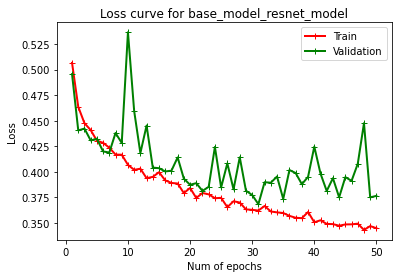

Plotting model type base_model with pretraining type vgg16_model


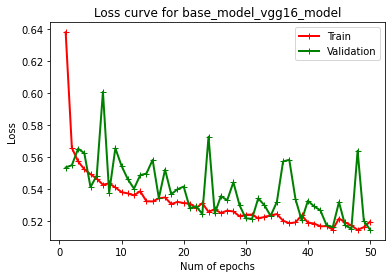

Plotting model type dropout_model with pretraining type resnet_model


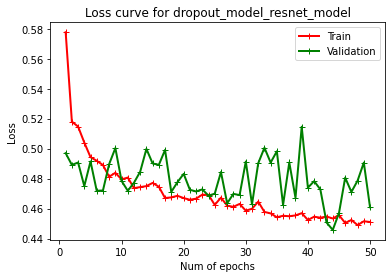

Plotting model type dropout_model with pretraining type vgg16_model


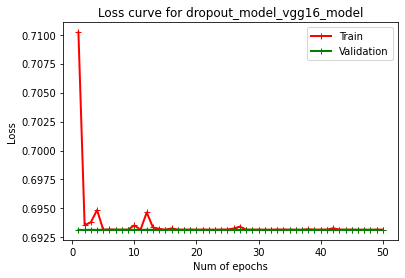

Plotting model type batchnorm_model with pretraining type resnet_model


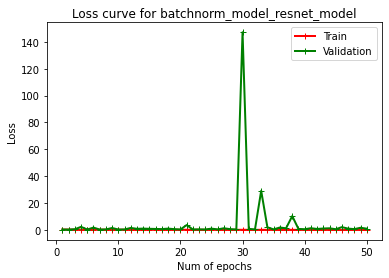

Plotting model type batchnorm_model with pretraining type vgg16_model


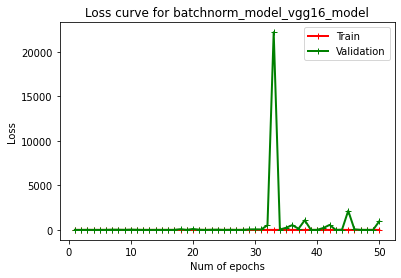

Plotting model type l1l2_model with pretraining type resnet_model


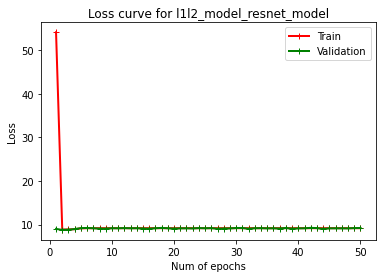

Plotting model type l1l2_model with pretraining type vgg16_model


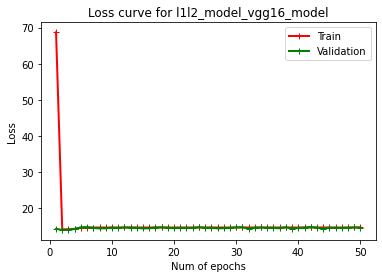

Plotting model type base_long_model with pretraining type resnet_model


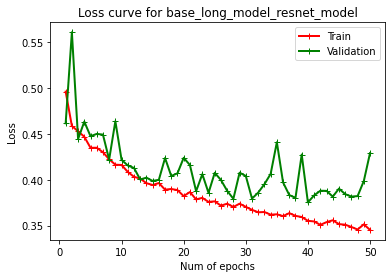

Plotting model type base_long_model with pretraining type vgg16_model


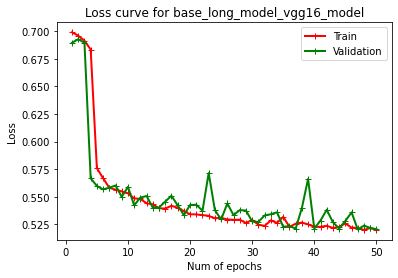

In [18]:
def plot_train_val_loss(train_loss, validation_loss, name):
  colours = ["r-+","g-+"]
  fig, ax = plt.subplots()
  epochs = list(range(1,len(train_loss) + 1))
  plt.plot(epochs, train_loss, colours[0], linewidth = 2, label='Training Loss')
  plt.plot(epochs, val_loss, colours[1], linewidth = 2, label='Validation Loss')
  ax.legend(["Train", "Validation"])
  plt.xlabel("Num of epochs")
  plt.ylabel("Loss")
  plt.title("Loss curve for {}".format(name))
  plt.show()

for model_type_name, model_types in models.items():
  for pretrain_type, model in model_types.items():
    print(f"Plotting model type {model_type_name} with pretraining type {pretrain_type}")
    train_loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    plot_train_val_loss(train_loss, val_loss, model_type_name + "_" + pretrain_type)

Now let's look at the accuracy curves of the models

Plotting model type base_model with pretraining type resnet_model


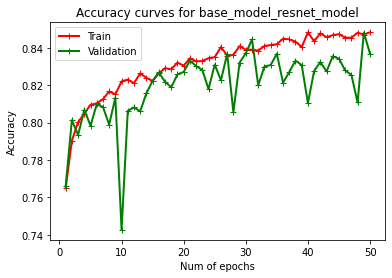

Plotting model type base_model with pretraining type vgg16_model


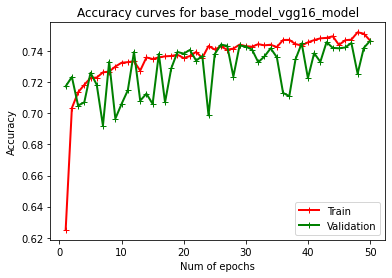

Plotting model type dropout_model with pretraining type resnet_model


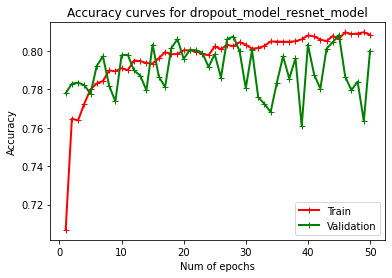

Plotting model type dropout_model with pretraining type vgg16_model


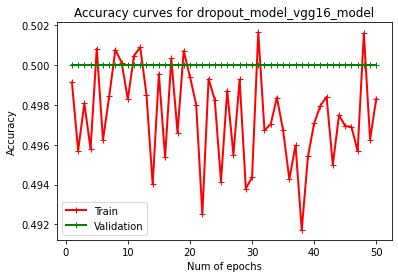

Plotting model type batchnorm_model with pretraining type resnet_model


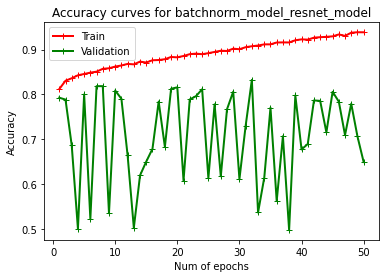

Plotting model type batchnorm_model with pretraining type vgg16_model


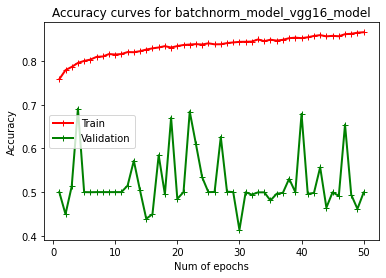

Plotting model type l1l2_model with pretraining type resnet_model


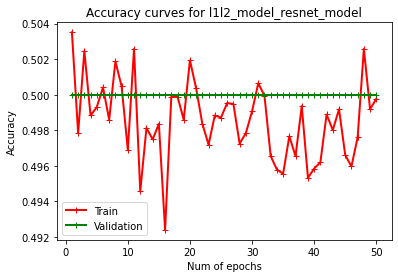

Plotting model type l1l2_model with pretraining type vgg16_model


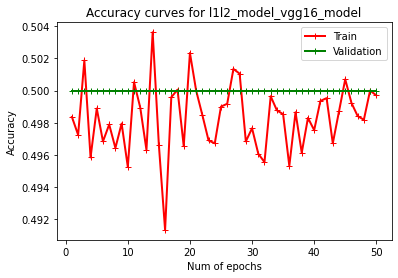

Plotting model type base_long_model with pretraining type resnet_model


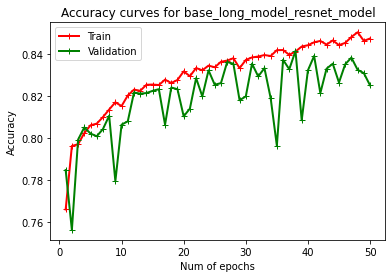

Plotting model type base_long_model with pretraining type vgg16_model


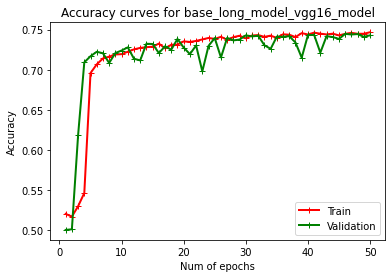

In [19]:
def plot_train_val_accuracy(train_loss, validation_loss, name):
  colours = ["r-+","g-+"]
  fig, ax = plt.subplots()
  epochs = list(range(1,len(train_loss) + 1))
  plt.plot(epochs, train_loss, colours[0], linewidth = 2, label='Training accuracy')
  plt.plot(epochs, val_loss, colours[1], linewidth = 2, label='Validation accuracy')
  ax.legend(["Train", "Validation"])
  plt.xlabel("Num of epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy curves for {}".format(name))
  plt.show()

for model_type_name, model_types in models.items():
  for pretrain_type, model in model_types.items():
    print(f"Plotting model type {model_type_name} with pretraining type {pretrain_type}")
    train_loss = model.history.history['accuracy']
    val_loss = model.history.history['val_accuracy']
    plot_train_val_accuracy(train_loss, val_loss, model_type_name + "_" + pretrain_type)

In [20]:
def print_metrics(model, features, true_labels):
    y_pred = model.predict(features)
    y_pred = np.where(y_pred >= 0.5, 1,0 )
    print(metrics.classification_report(true_labels, y_pred))
    mat = metrics.confusion_matrix(true_labels, y_pred)
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.show()

Plotting model type base_model with pretraining type resnet_model
119/119 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.89      0.85      1900
           1       0.88      0.78      0.83      1900

    accuracy                           0.84      3800
   macro avg       0.84      0.84      0.84      3800
weighted avg       0.84      0.84      0.84      3800



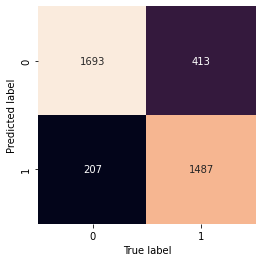

Plotting model type base_model with pretraining type vgg16_model
119/119 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1900
           1       0.78      0.69      0.73      1900

    accuracy                           0.75      3800
   macro avg       0.75      0.75      0.75      3800
weighted avg       0.75      0.75      0.75      3800



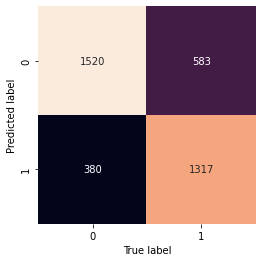

Plotting model type dropout_model with pretraining type resnet_model
119/119 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      1900
           1       0.86      0.72      0.78      1900

    accuracy                           0.80      3800
   macro avg       0.81      0.80      0.80      3800
weighted avg       0.81      0.80      0.80      3800



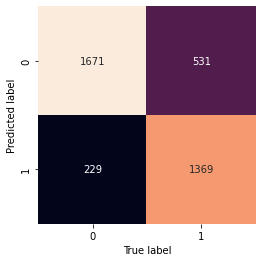

Plotting model type dropout_model with pretraining type vgg16_model
119/119 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1900
           1       0.50      1.00      0.67      1900

    accuracy                           0.50      3800
   macro avg       0.25      0.50      0.33      3800
weighted avg       0.25      0.50      0.33      3800



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


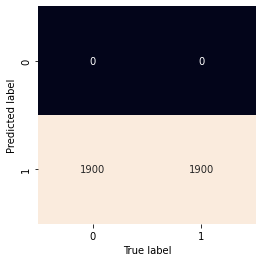

Plotting model type batchnorm_model with pretraining type resnet_model
119/119 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.77      0.43      0.55      1900
           1       0.60      0.87      0.71      1900

    accuracy                           0.65      3800
   macro avg       0.69      0.65      0.63      3800
weighted avg       0.69      0.65      0.63      3800



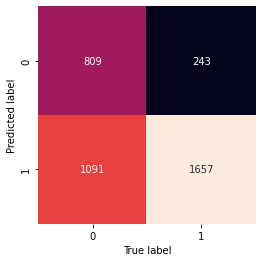

Plotting model type batchnorm_model with pretraining type vgg16_model
119/119 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.20      0.00      0.00      1900
           1       0.50      1.00      0.67      1900

    accuracy                           0.50      3800
   macro avg       0.35      0.50      0.33      3800
weighted avg       0.35      0.50      0.33      3800



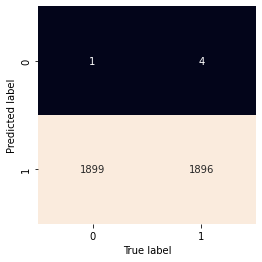

Plotting model type l1l2_model with pretraining type resnet_model
119/119 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1900
           1       0.50      1.00      0.67      1900

    accuracy                           0.50      3800
   macro avg       0.25      0.50      0.33      3800
weighted avg       0.25      0.50      0.33      3800



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


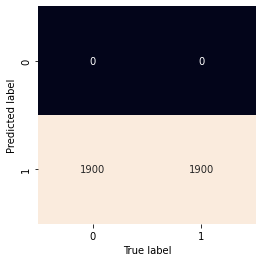

Plotting model type l1l2_model with pretraining type vgg16_model
119/119 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1900
           1       0.00      0.00      0.00      1900

    accuracy                           0.50      3800
   macro avg       0.25      0.50      0.33      3800
weighted avg       0.25      0.50      0.33      3800



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


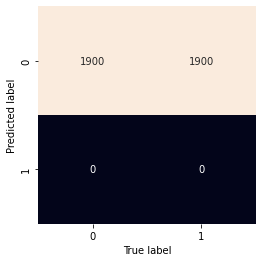

Plotting model type base_long_model with pretraining type resnet_model
119/119 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1900
           1       0.81      0.85      0.83      1900

    accuracy                           0.82      3800
   macro avg       0.83      0.82      0.82      3800
weighted avg       0.83      0.82      0.82      3800



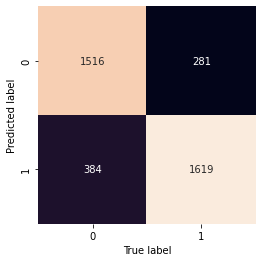

Plotting model type base_long_model with pretraining type vgg16_model
119/119 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      1900
           1       0.79      0.66      0.72      1900

    accuracy                           0.74      3800
   macro avg       0.75      0.74      0.74      3800
weighted avg       0.75      0.74      0.74      3800



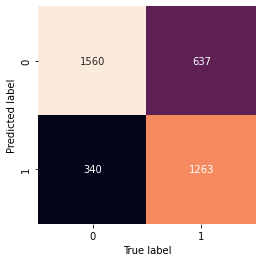

In [21]:
for model_type_name, model_types in models.items():
  for pretrain_type, model in model_types.items():
    print(f"Plotting model type {model_type_name} with pretraining type {pretrain_type}")
    _,_,val_x,val_y,_,_ = extract_data_splits(pretrain_type)
    print_metrics(model, val_x, val_y)

### Test set

We use the average precision score to evaluate the model.

Plotting model type base_model with pretraining type resnet_model
179/179 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      2850
           1       0.88      0.79      0.83      2850

    accuracy                           0.84      5700
   macro avg       0.85      0.84      0.84      5700
weighted avg       0.85      0.84      0.84      5700



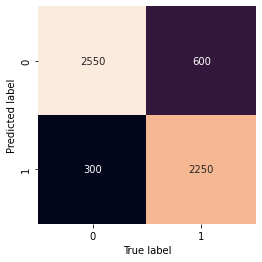

Plotting model type base_model with pretraining type vgg16_model
179/179 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      2850
           1       0.78      0.70      0.74      2850

    accuracy                           0.75      5700
   macro avg       0.75      0.75      0.75      5700
weighted avg       0.75      0.75      0.75      5700



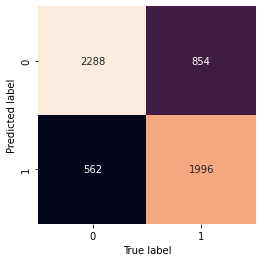

Plotting model type dropout_model with pretraining type resnet_model
179/179 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      2850
           1       0.86      0.73      0.79      2850

    accuracy                           0.81      5700
   macro avg       0.81      0.81      0.80      5700
weighted avg       0.81      0.81      0.80      5700



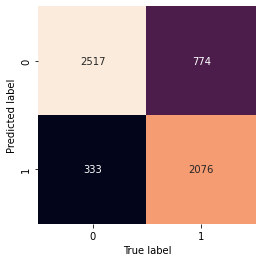

Plotting model type dropout_model with pretraining type vgg16_model
179/179 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2850
           1       0.50      1.00      0.67      2850

    accuracy                           0.50      5700
   macro avg       0.25      0.50      0.33      5700
weighted avg       0.25      0.50      0.33      5700



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


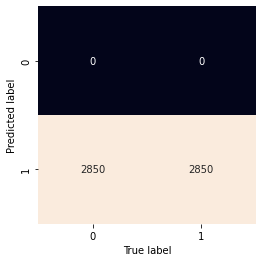

Plotting model type batchnorm_model with pretraining type resnet_model
179/179 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.79      0.43      0.56      2850
           1       0.61      0.89      0.72      2850

    accuracy                           0.66      5700
   macro avg       0.70      0.66      0.64      5700
weighted avg       0.70      0.66      0.64      5700



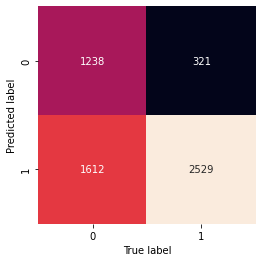

Plotting model type batchnorm_model with pretraining type vgg16_model
179/179 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.14      0.00      0.00      2850
           1       0.50      1.00      0.67      2850

    accuracy                           0.50      5700
   macro avg       0.32      0.50      0.33      5700
weighted avg       0.32      0.50      0.33      5700



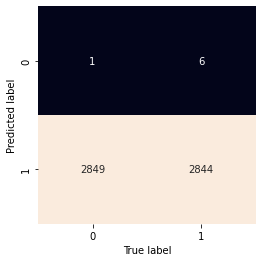

Plotting model type l1l2_model with pretraining type resnet_model
179/179 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2850
           1       0.50      1.00      0.67      2850

    accuracy                           0.50      5700
   macro avg       0.25      0.50      0.33      5700
weighted avg       0.25      0.50      0.33      5700



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


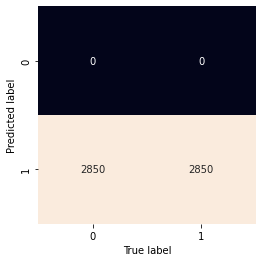

Plotting model type l1l2_model with pretraining type vgg16_model
179/179 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2850
           1       0.00      0.00      0.00      2850

    accuracy                           0.50      5700
   macro avg       0.25      0.50      0.33      5700
weighted avg       0.25      0.50      0.33      5700



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


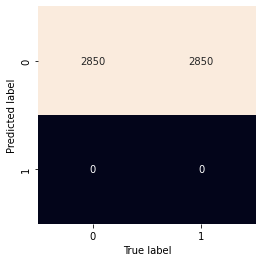

Plotting model type base_long_model with pretraining type resnet_model
179/179 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2850
           1       0.81      0.85      0.83      2850

    accuracy                           0.83      5700
   macro avg       0.83      0.83      0.83      5700
weighted avg       0.83      0.83      0.83      5700



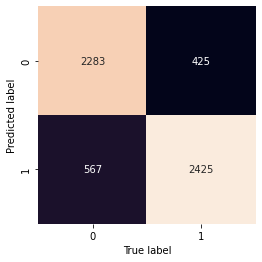

Plotting model type base_long_model with pretraining type vgg16_model
179/179 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.71      0.82      0.77      2850
           1       0.79      0.67      0.73      2850

    accuracy                           0.75      5700
   macro avg       0.75      0.75      0.75      5700
weighted avg       0.75      0.75      0.75      5700



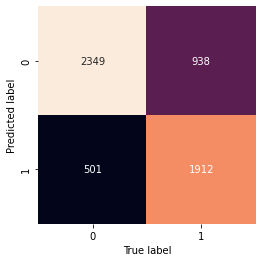

In [22]:
for model_type_name, model_types in models.items():
  for pretrain_type, model in model_types.items():
    print(f"Plotting model type {model_type_name} with pretraining type {pretrain_type}")
    _,_,_,_,test_x,test_y = extract_data_splits(pretrain_type)
    print_metrics(model, test_x, test_y)